# INFO-F-422 - Statistical foundations of machine learning Project 2024-2025
_2024-2025 - Gianluca Bontempi, Cédric Simar, Pascal Tribell_



### The Goats 🐐
_Antoine Figula, Arthur Robert, Victor Wattel_


## 0. Data loading and visualization



In [50]:
#libraries 
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt


In [45]:
#guided dataset and testset
guided_dataset_X = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_dataset_X.npy')
guided_dataset_y = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_dataset_y.npy')
guided_testset_X = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_testset_X.npy')

#freemoves dataset and testset
freemoves_dataset_X = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_dataset_X.npy')
freemoves_dataset_y = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_dataset_y.npy')
freemoves_testset_X = np.load('/Users/victorwattel/Library/Mobile Documents/com~apple~CloudDocs/Desktop/INFO-F-422 Statistical fundations of ML /Project/F422 EMG project data/guided/guided_testset_X.npy')


In [ ]:
print(guided_dataset_X.shape) #5 sessions, 8 electrodes, 230000 time points
print(guided_dataset_y.shape) #5 sessions, 51 hand poses, 230000 time points
print(guided_testset_X.shape) #5 sessions, 332 windows, 8 electrodes, 230000 time points
print(freemoves_dataset_X.shape)
print(freemoves_dataset_y.shape)
print(freemoves_testset_X.shape)

(5, 8, 230000)
(5, 51, 230000)
(5, 332, 8, 500)
(5, 8, 230000)
(5, 51, 230000)
(5, 332, 8, 500)


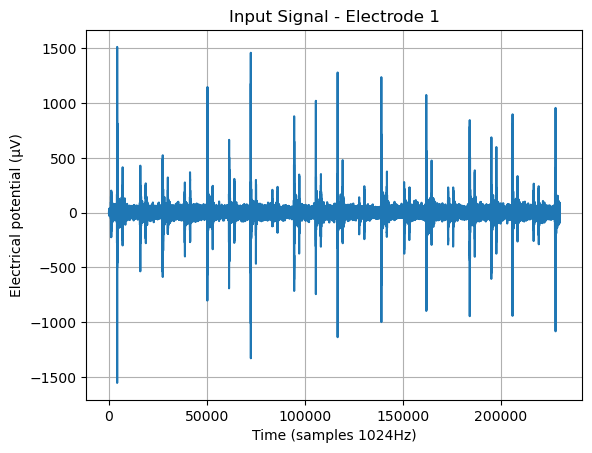

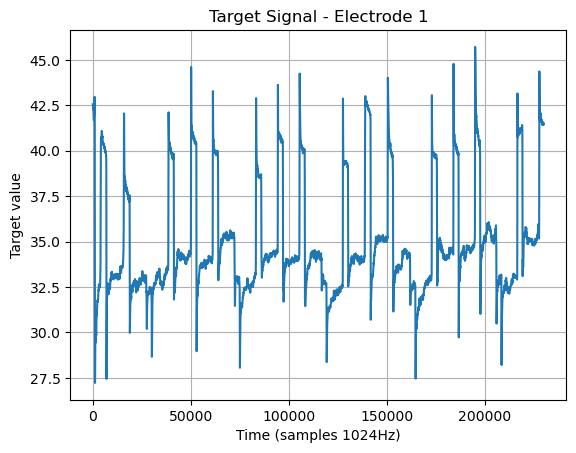

In [68]:
import matplotlib.pyplot as plt

# Plot first EMG signal (e.g. from channel 0)
plt.plot(guided_dataset_X[0, 0, :])
plt.title("Input Signal - Electrode 1")
plt.xlabel("Time (samples 1024Hz)")
plt.ylabel("Electrical potential (μV)")
plt.grid(True)
plt.show()

# Plot corresponding output/target signal
plt.figure()
plt.plot(guided_dataset_y[0, 0, :])
plt.title("Target Signal - Electrode 1")
plt.xlabel("Time (samples 1024Hz)")
plt.ylabel("Target value")
plt.grid(True)
plt.show()


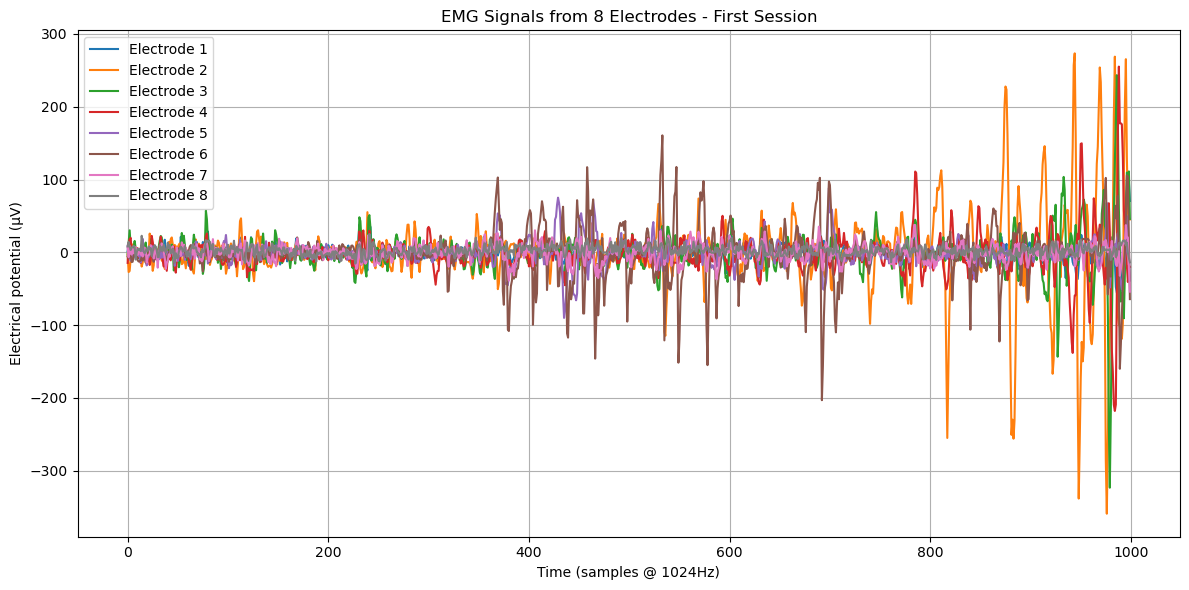

In [ ]:
# Plot EMG signals from 8 electrodes (first session)
fig, ax = plt.subplots(figsize=(12, 6))  # Un seul subplot

for i in range(8):
    ax.plot(guided_dataset_X[0, i, :1000], label=f'Electrode {i+1}') #Fixed time sample of 1000 hz

ax.set_title('EMG Signals from 8 Electrodes - First Session')
ax.set_xlabel('Time (samples 1024Hz)')
ax.set_ylabel('Electrical potential (μV)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()
plt.show()


## 1. Data Preparation
- 1.1 Signal filtering *(optional)*


- 1.2 Sliding window creation with overlap


In [70]:
window_size = 500 # 500 ms window
overlap = 250 # 50% overlap
n_windows = (X.shape[2]-window_size)//overlap + 1 #Windows have overlap over next windows
X_windowed = np.zeros((X.shape[0], X.shape[1], n_windows, window_size))
y_windowed = np.zeros((y.shape[0], y.shape[1], n_windows))
for i in range(n_windows): 
    X_windowed[:,:,i,:] = X[:,:,(i*overlap):(i*overlap+window_size)]
    y_windowed[:,:,i] = y[:,:,i*overlap+window_size-1]
print(X_windowed.shape) # 5 sessions, 8 electrodes, 919 windows, 500 time points
print(y_windowed.shape)

(5, 8, 919, 500)
(5, 51, 919)


(2757, 8, 500)
40.58962943682379


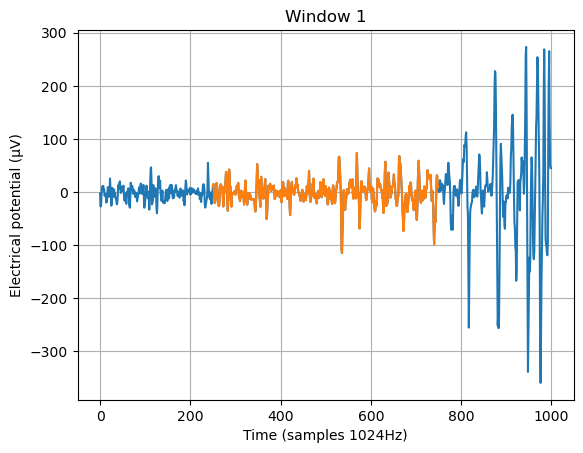

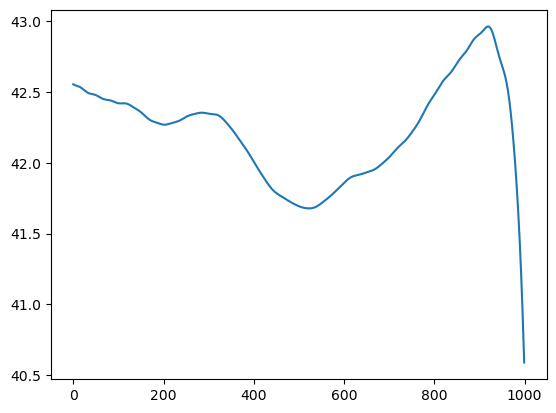

In [76]:
plt.plot(X[0,1,0:1000])
print(X_train_stacked.shape)
plt.title("Window 1")
plt.xlabel("Time (samples 1024Hz)")
plt.ylabel("Electrical potential (μV)")
plt.grid(True)
plt.plot(np.arange(250, 750),X_train_stacked[1,1,:])
plt.figure()
plt.plot(y[0,0,0:1000])
print(y_train_stacked[2,0])

- 1.3 Preparation of training and validation sets


In [ ]:
n_sessions = len(X_windowed) #We know that we have 5 sessions
for fold in range(n_sessions):
    val_session = fold
    train_sessions = [i for i in range(n_sessions) if i != val_session]

    # Stack training sessions
    X_train = np.stack([X_windowed[i] for i in train_sessions])
    y_train = np.stack([y_windowed[i] for i in train_sessions])
    
    # Single session as validation
    X_val = X_windowed[val_session]
    y_val = y_windowed[val_session]
    
    print(f"Fold {fold + 1}/{n_sessions}")
    print(f"  Validation session: {val_session}")
    print(f"  Training sessions: {train_sessions}")
    



Fold 1/5
  Validation session: 0
  Training sessions: [1, 2, 3, 4]
Fold 2/5
  Validation session: 1
  Training sessions: [0, 2, 3, 4]
Fold 3/5
  Validation session: 2
  Training sessions: [0, 1, 3, 4]
Fold 4/5
  Validation session: 3
  Training sessions: [0, 1, 2, 4]
Fold 5/5
  Validation session: 4
  Training sessions: [0, 1, 2, 3]


## 2. Cross-Validation
- 2.1 Cross-validation strategy


We chose to work with a K fold cross validation with each session being the folds.
In our case, we don't need Kfold from sklearn library because we manually assign the folds being the sessions. 

- 2.2 Justification and prevention of *data leakage*


A data leakange can arrive because of the overlap in the window setting, so a way to prevent this leakage is to choose a different session with new and separated windows. In other words, we choose to do the Cross validation with the 5 sessions, we split along sessions and we do the CV to prevent the overlap overfitting risk inside sessions. 

## 3. Baseline Approach
- 3.1 Implementation of time-based feature extractor
- 3.2 Selection and evaluation of two regression models
- 3.3 Selection of the best features
- 3.4 Building a `scikit-learn` pipeline *(feature extraction + model)*
- 3.5 Documentation and visualization

## 4. Advanced Approach
- 4.1 Implementation with covariance matrices (`PyRiemann`)  
  *or*  
- 4.2 Implementation with neural network (`PyTorch`)
- 4.3 Comparison with the baseline approach
- 4.4 Documentation

## 5. Ensemble Strategies
- 5.1 Simple averaging of predictions
- 5.2 Meta-learner *(stacking)*
- 5.3 Performance comparison
- 5.4 Bias-variance analysis

## 6. Final Predictions
- 6.1 Selection of final models for `guided` and `freemoves`
- 6.2 Predictions on test files
- 6.3 Generation of `team_submission.csv`

## 7. *(Bonus)* Prediction Visualization
- 7.1 Integration in the visualization app
- 7.2 Qualitative evaluation of realism


Package importation 

Data loading

We choose to do the Cross validation with the 5 sessions, we split along sessions and we do the CV to prevent the overlap overfitting risk inside sessions. 

In [30]:
X_train = np.stack(X_windowed[0:3,:,:,:])
y_train = np.stack(y_windowed[0:3,:,:])
X_test = X_windowed[3,:,:,:]
y_test = y_windowed[3,:,:]
X_val = X_windowed[4,:,:,:]
y_val = y_windowed[4,:,:]

In [31]:
print(X_test.shape)
print(y_train.shape)

(8, 919, 500)
(3, 51, 919)


We adjust dimensions 

In [32]:
X_train_stacked = X_train.transpose(1,0,2,3).reshape(X_train.shape[1], -1, window_size)# 
y_train_stacked = y_train.transpose(1,0,2).reshape(y_train.shape[1], -1)
X_train_stacked = X_train_stacked.transpose(1,0,2)
y_train_stacked = y_train_stacked.transpose(1,0)

X_test_stacked = X_test.transpose(1,0,2)
y_test_stacked = y_test.transpose(1,0)

X_val_stacked = X_val.transpose(1,0,2)
y_val_stacked = y_val.transpose(1,0)

print(X_train_stacked.shape)
print(y_train_stacked.shape)

(2757, 8, 500)
(2757, 51)


Orange must be along blue

The Y to predict must be the Y at the end of the window

(2757, 8, 500)
40.58962943682379


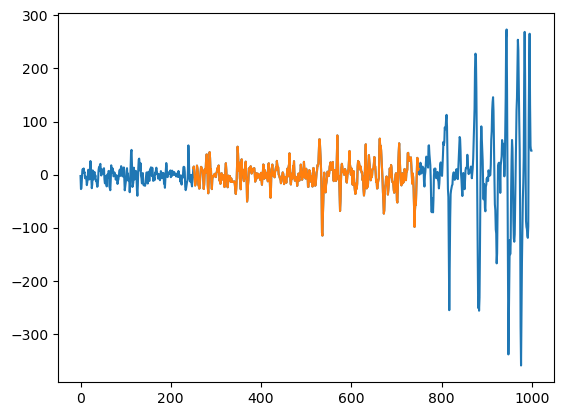

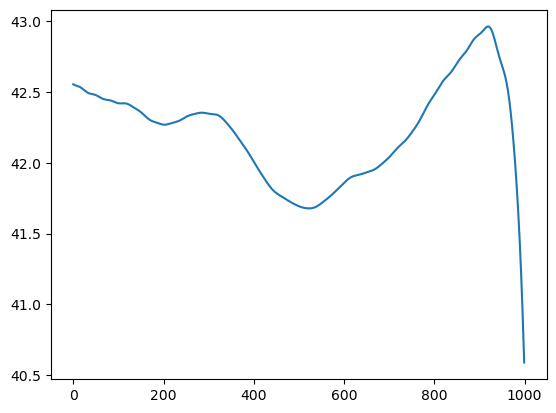

In [33]:
plt.plot(X[0,1,0:1000])
print(X_train_stacked.shape)
plt.plot(np.arange(250, 750),X_train_stacked[1,1,:])
plt.figure()
plt.plot(y[0,0,0:1000])
print(y_train_stacked[2,0])

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

class CommonFeaturesTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that extract all common features.
    """
    def __init__(self, sigma):
        self.sigma = sigma

    def MAV(self, X): #Moving absolute value
        return np.mean(np.abs(X),axis = 2)
    
    def RMS(self, X):
        return np.mean(X*X,axis = 2)

    def Var(self, X):
        return np.var(X,axis = 2,ddof=1)
        
    def STD(self, X):
        return np.sqrt(self.Var(X))
        
    def ZC(self, X):
        return np.sum(X[:,:,0:499]*X[:,:,1:500]<0,axis = 2)
        
    def MPR(self, X):
        return np.mean(np.abs(X)>self.sigma,axis = 2)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        features = np.stack([self.MAV(X),self.RMS(X),self.Var(X),self.STD(X),self.ZC(X),self.MPR(X)],axis = 2)
        res = features.reshape(features.shape[0],-1)
        return res

In [35]:
def NMSE(y_true, y_pred):
    return np.sum((y_pred-y_true)**2)/np.sum((np.mean(y_true,axis = 0)-y_true)**2)

def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_pred-y_true)**2))

In [36]:
custom_pipeline = Pipeline([
    ("custom_features", CommonFeaturesTransformer(sigma = 200)),
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

In [37]:
custom_pipeline.fit(X_train_stacked, y_train_stacked)
y_pred = custom_pipeline.predict(X_test_stacked)

print(NMSE(y_test_stacked,y_pred))
print(RMSE(y_test_stacked,y_pred))

0.22427015845438542
6.653000854029159


['MAV_1', 'RMS_1', 'Var_1', 'STD_1', 'ZC_1', 'MPR_1', 'MAV_2', 'RMS_2', 'Var_2', 'STD_2', 'ZC_2', 'MPR_2', 'MAV_3', 'RMS_3', 'Var_3', 'STD_3', 'ZC_3', 'MPR_3', 'MAV_4', 'RMS_4', 'Var_4', 'STD_4', 'ZC_4', 'MPR_4', 'MAV_5', 'RMS_5', 'Var_5', 'STD_5', 'ZC_5', 'MPR_5', 'MAV_6', 'RMS_6', 'Var_6', 'STD_6', 'ZC_6', 'MPR_6', 'MAV_7', 'RMS_7', 'Var_7', 'STD_7', 'ZC_7', 'MPR_7', 'MAV_8', 'RMS_8', 'Var_8', 'STD_8', 'ZC_8', 'MPR_8']


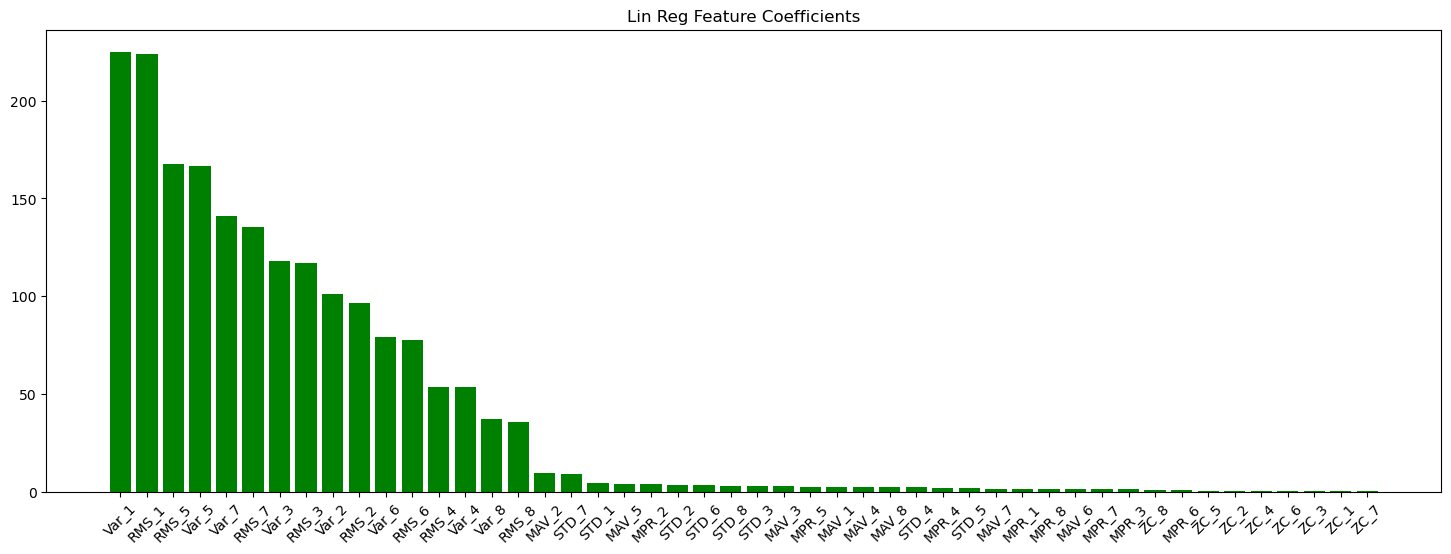

In [38]:
feature_names = []
feature_types = ["MAV", "RMS", "Var", "STD", "ZC", "MPR"]
channels = range(1, 9)

for ch in channels:
    for feat in feature_types:
        feature_names.append(f"{feat}_{ch}")
print(feature_names)

t = CommonFeaturesTransformer(sigma = 200)
X_t = t.transform(X_train_stacked)

coefs = custom_pipeline.named_steps["regressor"].coef_
coefs = np.mean(np.abs(coefs), axis=0)
coefs_sorted_idx = np.argsort(coefs)[::-1]

sorted_feature_names = []
for i in coefs_sorted_idx:
    sorted_feature_names.append(feature_names[i])

plt.figure(figsize=(18, 6))
plt.title("Lin Reg Feature Coefficients")
plt.bar(range(len(coefs)), coefs[coefs_sorted_idx], align='center', color='green')
plt.xticks(range(len(coefs)), sorted_feature_names, rotation=45)
plt.show()

If coeff are big, the model use them a lot 

In [39]:
from sklearn.ensemble import RandomForestRegressor

custom_pipeline2 = Pipeline([
    ("custom_features", CommonFeaturesTransformer(sigma = 500)),
    ("scaler", StandardScaler()),
    ("regressor", RandomForestRegressor(n_estimators=200))
])

custom_pipeline2.fit(X_train_stacked, y_train_stacked)
y_pred = custom_pipeline2.predict(X_test_stacked)
                                 
print(NMSE(y_test_stacked,y_pred))
print(RMSE(y_test_stacked,y_pred))

0.10223327885552756
4.491878278342816


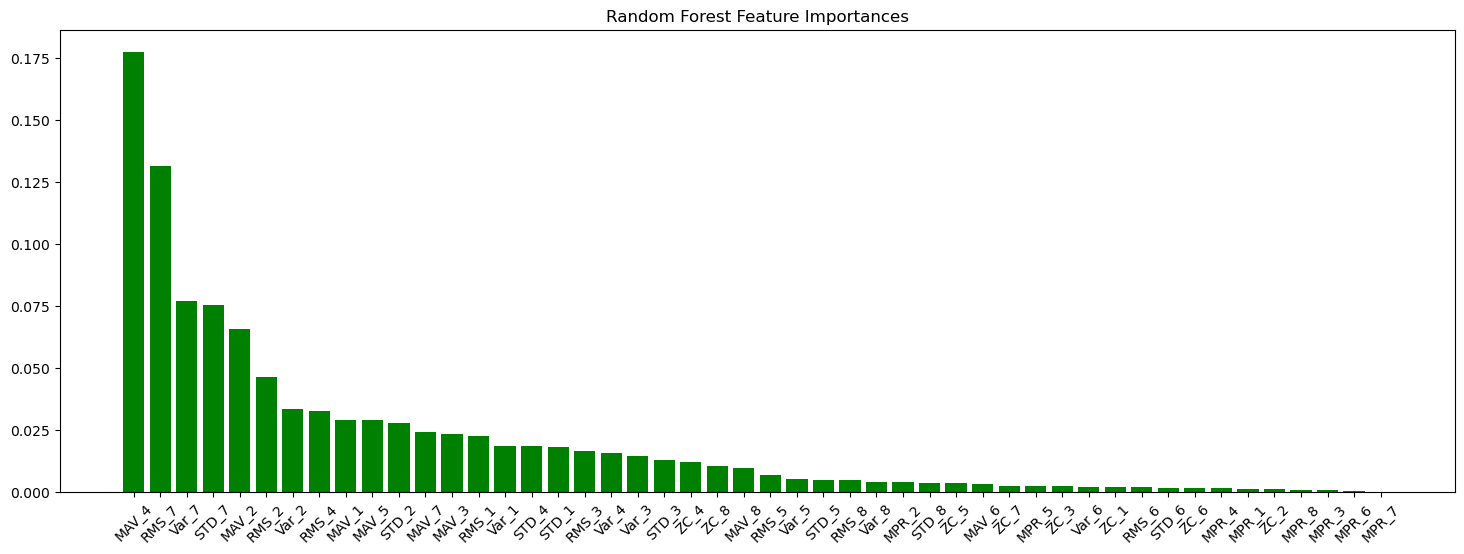

In [40]:
forest_importances = custom_pipeline2.named_steps["regressor"].feature_importances_
forest_sorted_idx = np.argsort(forest_importances)[::-1]

sorted_feature_names = []
for i in forest_sorted_idx:
    sorted_feature_names.append(feature_names[i])
    
plt.figure(figsize=(18, 6))
plt.title("Random Forest Feature Importances")
plt.bar(range(len(forest_importances)), forest_importances[forest_sorted_idx], align='center', color='green')
plt.xticks(range(len(forest_importances)), sorted_feature_names, rotation=45)
plt.show()

In [41]:
class FullFeaturesTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that extract all features. A VOIR
    """
    def __init__(self, sigma):
        self.sigma = sigma

    def MAV(self, X):
        return np.mean(np.abs(X),axis = 2)
    
    def RMS(self, X):
        return np.mean(X*X,axis = 2)

    def Var(self, X):
        return np.var(X,axis = 2,ddof=1)
        
    def STD(self, X):
        return np.sqrt(self.Var(X))
        
    def ZC(self, X):
        return np.sum(X[:,:,0:499]*X[:,:,1:500]<0,axis = 2)
        
    def MPR(self, X):
        return np.mean(np.abs(X)>self.sigma,axis = 2)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        features = np.stack([self.MAV(X),self.RMS(X),self.Var(X),self.STD(X),self.ZC(X),self.MPR(X)],axis = 2)
        res = features.reshape(features.shape[0],-1)
        return res

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
print(X_train_stacked.shape)
print(y_train_stacked.shape)

X_train_torch = X_train_stacked.reshape(-1, 1, X_train_stacked.shape[1], X_train_stacked.shape[2])
X_train_torch = torch.from_numpy(X_train_torch).float().to(device)

y_train_torch = torch.from_numpy(y_train_stacked).float().to(device)

X_test_torch = X_test_stacked.reshape(-1, 1, X_test_stacked.shape[1], X_test_stacked.shape[2])
X_test_torch = torch.from_numpy(X_test_torch).float().to(device)
y_test_torch = torch.from_numpy(y_test_stacked).float().to(device)


(2757, 8, 500)
(2757, 51)


In [44]:
# This CNN will perform a regression task (e.g., predicting a real-valued output from an image).
# We'll use two convolution layers (with 2x2 max pooling after each), then two fully-connected layers,
# include dropout with probability=0.25, and weight decay in the optimizer for regularization.
class ShallowConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 40, (1, 13), bias=False)
        self.conv2 = nn.Conv2d(40, 40, (8, 1), bias=False)
        self.Bn1   = nn.BatchNorm2d(40)
        self.AvgPool1 = nn.AvgPool2d((1, 35), stride=(1, 7))
        self.Drop1 = nn.Dropout(0.25)
        self.classifier = nn.Linear(40*65, 51, bias=True)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.Bn1(x)
        x = x ** 2
        x = self.AvgPool1(x)
        x = torch.log(x)
        x = self.Drop1(x)
        x = x.view(-1, 40*65)
        x = self.classifier(x)
        
        return x



# We'll wrap the data in TensorDatasets and DataLoaders for batching
train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset   = TensorDataset(X_test_torch, y_test_torch)

train_loader  = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=50, shuffle=False)

# Instantiate our CNN model
model = ShallowConvNet().to(device)

# We'll use MSELoss for this regression task
criterion = nn.MSELoss()

# We'll use Adam optimizer with weight decay for L2 regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Setup for training with early stopping
max_epochs         = 150
patience           = 20  # number of epochs with no improvement allowed
best_val_loss      = float('inf')
epochs_no_improve  = 0
best_model_path    = "best_model.pth"

for epoch in range(max_epochs):
    # Train mode: enables dropout, etc.
    model.train()
    running_train_loss = 0.0
    
    # Fetch mini-batches from the training loader
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass -> compute predictions
        preds = model(X_batch)
        
        # Compute MSE loss for regression
        loss = criterion(preds, y_batch)
        
        # Backward pass -> compute gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        running_train_loss += loss.item()
    
    # Compute average training loss for this epoch
    avg_train_loss = running_train_loss / len(train_loader)
    
    # Validation phase (disable dropout, etc.)
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for Xv_batch, yv_batch in val_loader:
            Xv_batch = Xv_batch.to(device)
            yv_batch = yv_batch.to(device)
            # Forward pass on validation set
            val_preds = model(Xv_batch)
            val_loss = criterion(val_preds, yv_batch)
            running_val_loss += val_loss.item()
    
    avg_val_loss = running_val_loss / len(val_loader)
    
    print(f"Epoch [{epoch+1}/{max_epochs}]  "
          f"Train MSE: {avg_train_loss:.4f}  "
          f"Val MSE: {avg_val_loss:.4f}")
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        # If validation improves, update best_val_loss and reset patience counter
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save current model as best
        torch.save(model.state_dict(), best_model_path)
        print("  Best model saved (improved validation MSE).")
    else:
        epochs_no_improve += 1
        # If no improvement for 'patience' epochs, stop
        if epochs_no_improve >= patience:
            print("Early stopping triggered (no improvement).")
            break

print("\nTraining complete. Loading best model for final checks.")
best_model = ShallowConvNet().to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

# We can now evaluate 'best_model' on the validation set (or test set if we had one).
# For instance, a quick check of final validation MSE:
final_val_loss = 0.0
with torch.no_grad():
    for Xv_batch, yv_batch in val_loader:
        Xv_batch = Xv_batch.to(device)
        yv_batch = yv_batch.to(device)
        val_preds = best_model(Xv_batch)
        val_loss = criterion(val_preds, yv_batch)
        final_val_loss += val_loss.item()
print(f"Final validation MSE (best model): {final_val_loss / len(val_loader):.4f}")

Epoch [1/150]  Train MSE: 283.8752  Val MSE: 161.6220
  Best model saved (improved validation MSE).
Epoch [2/150]  Train MSE: 200.2186  Val MSE: 135.4711
  Best model saved (improved validation MSE).
Epoch [3/150]  Train MSE: 167.9521  Val MSE: 109.3058
  Best model saved (improved validation MSE).
Epoch [4/150]  Train MSE: 132.2374  Val MSE: 87.4835
  Best model saved (improved validation MSE).
Epoch [5/150]  Train MSE: 111.2281  Val MSE: 71.0632
  Best model saved (improved validation MSE).
Epoch [6/150]  Train MSE: 93.5000  Val MSE: 60.7004
  Best model saved (improved validation MSE).
Epoch [7/150]  Train MSE: 84.0917  Val MSE: 57.2230
  Best model saved (improved validation MSE).
Epoch [8/150]  Train MSE: 75.5261  Val MSE: 52.2124
  Best model saved (improved validation MSE).
Epoch [9/150]  Train MSE: 74.5878  Val MSE: 53.2984
Epoch [10/150]  Train MSE: 71.5631  Val MSE: 48.0127
  Best model saved (improved validation MSE).
Epoch [11/150]  Train MSE: 69.6296  Val MSE: 48.0916
Epoc

KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
    y_pred = best_model(X_test_torch).cpu().numpy()
    print(NMSE(y_test_stacked,y_pred))
    print(RMSE(y_test_stacked,y_pred))

0.6396339854703442
8.66019999835021
